In [78]:
import pandas as pd
from decimal import Decimal
import ijson
import time
import csv
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tabulate import tabulate

### Converting JSON to the CSV

Reference: https://www.kaggle.com/code/shreyasbhatk/csv-conversion-all-fields

In [3]:
start = time.process_time()

PAPER = []
Author = []
count = 0

with open('./dblp.v12.json', "rb") as f, open("./output.csv", "w", newline="") as csvfile:
    fieldnames = ['id', 'title', 'year', 'author_name', 'author_org', 'author_id', 'n_citation', 'doc_type',
                  'reference_count', 'references', 'venue_id', 'venue_name', 'venue_type', 'doi', 'keyword','volume','issue','publisher',
                  'weight', 'indexed_keyword', 'inverted_index']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for i, element in enumerate(ijson.items(f, "item")):
        paper = {}
        paper['id'] = element['id']
        paper['title'] = element['title']

        year = element.get('year')
        if year:
            paper['year'] = year
        else:
            paper['year'] = np.nan

        author = element.get('authors')
        if author:
            Author = element['authors']
            author_name = []
            author_org = []
            author_id = []

            for i in Author:
                if 'name' in i and 'id' in i and 'org' in i:
                    author_name.append(str(i['name']))  # Convert to string
                    author_id.append(str(i['id']))
                    author_org.append(str(i['org']))
                else:
                    author_name.append(str(np.nan))  # Convert to string
                    author_id.append(str(np.nan))
                    author_org.append(str(np.nan))

            paper['author_name'] = ';'.join(author_name)
            paper['author_org'] = ';'.join(author_org)
            paper['author_id'] = ';'.join(author_id)

        n_citation = element.get('n_citation')
        if n_citation:
            paper['n_citation'] = n_citation
        else:
            paper['n_citation'] = np.nan

        doc_type = element.get('doc_type')
        if doc_type:
            paper['doc_type'] = doc_type
        else:
            paper['doc_type'] = np.nan

        references = element.get('references')
        if references:
            paper['reference_count'] = len(references)
            paper['references'] = ';'.join(str(int(r)) for r in references)
        else:
            paper['references'] = np.nan

        venue = element.get('venue')
        if venue:
            if 'id' in venue and 'raw' in venue and 'type' in venue:
                paper['venue_id'] = str(venue['id'])
                paper['venue_name'] = venue['raw']
                paper['venue_type'] = venue['type']
            else:
                paper['venue_id'] = np.nan
                paper['venue_name'] = np.nan
                paper['venue_type'] = np.nan
        else:
            paper['venue_id'] = np.nan
            paper['venue_name'] = np.nan
            paper['venue_type'] = np.nan

        doi = element.get('doi')
        if doi:
            paper['doi'] = f"https://doi.org/{doi}"
        else:
            paper['doi'] = np.nan

        fos = element.get('fos')
        if fos:
            fosunparsed = element['fos']
            keyword = []
            weight = []

            for i in fosunparsed:
                if isinstance(i['w'], (int, float, Decimal)):
                    keyword.append(str(i['name']))  # Convert to string
                    weight.append(str(i['w']))
                else:
                    keyword.append(str(np.nan))  # Convert to string
                    weight.append(str(np.nan))

        else:
            keyword = []
            weight = []

        paper['keyword'] = ';'.join(keyword)
        paper['weight'] = ';'.join(weight)

        
        publisher= element.get('publisher')
        if publisher:
            paper['publisher']=publisher
        else:
            paper['publisher']=np.nan
        
            
        count += 1
        writer.writerow(paper)

        if count % 48000 == 0:
            print(f"{count}:{round((time.process_time() - start), 2)}s ", end="")

48000:2.04s 96000:4.09s 144000:6.14s 192000:8.2s 240000:10.26s 288000:12.93s 336000:15.76s 384000:18.55s 432000:21.36s 480000:24.22s 528000:27.0s 576000:29.8s 624000:32.57s 672000:35.5s 720000:38.46s 768000:41.44s 816000:44.47s 864000:47.51s 912000:50.53s 960000:53.55s 1008000:56.57s 1056000:59.59s 1104000:62.61s 1152000:65.6s 1200000:68.61s 1248000:71.67s 1296000:74.7s 1344000:77.72s 1392000:80.74s 1440000:83.75s 1488000:86.78s 1536000:89.8s 1584000:92.81s 1632000:95.81s 1680000:98.81s 1728000:101.85s 1776000:104.85s 1824000:107.85s 1872000:110.86s 1920000:113.9s 1968000:116.89s 2016000:119.95s 2064000:122.99s 2112000:126.08s 2160000:129.16s 2208000:132.25s 2256000:135.4s 2304000:138.46s 2352000:141.57s 2400000:144.65s 2448000:147.75s 2496000:150.89s 2544000:154.0s 2592000:157.09s 2640000:160.2s 2688000:163.28s 2736000:166.41s 2784000:169.49s 2832000:172.57s 2880000:175.66s 2928000:178.62s 2976000:181.77s 3024000:184.68s 3072000:187.63s 3120000:190.68s 3168000:192.88s 3216000:194.95s 

In [6]:
# Read the dataset in chunks since it's large
chunksize = 100000
chunk_list = []

start = time.process_time()

# Save it
chunks = pd.read_csv('./output.csv',chunksize=chunksize)

for chunk in chunks:
    chunk_list.append(chunk)

# Concat all chunks
output = pd.concat(chunk_list,ignore_index=True)

elapsed_time = time.process_time() - start
print(f"{elapsed_time} seconds")

36.660471 seconds


### 1. Data

In [7]:
# Sort the 'output' DataFrame by the 'n_citation' column in descending order
df_sorted = output.sort_values(by='n_citation', ascending=False)

# Select the top 10,000 rows from the sorted DataFrame
top_10000_papers = df_sorted.head(10000)

# Save the resulting DataFrame to a CSV file named 'df.csv' without including the index column
top_10000_papers.to_csv('top_10000_papers.csv', index=False)

I have saved a new csv file that we are going to use in the future. Now we need to check if there are any missing values and process them if there are any.

In [8]:
# Check for missing values in the 'top_10000_papers' DataFrame
missing_values = top_10000_papers.isnull()

# Count the number of missing values in each column
missing_count = missing_values.sum()

# Display the count of missing values for each column
print("Missing Values in Each Column:")
print(missing_count)

# Check if there are any missing values in the entire DataFrame
if missing_values.any().any():
    print("There are missing values in the DataFrame.")
else:
    print("No missing values in the DataFrame.")

Missing Values in Each Column:
id                     0
title                  0
year                   0
author_name          488
author_org           488
author_id            488
n_citation             0
doc_type             350
reference_count     1202
references          1202
venue_id             984
venue_name           984
venue_type           984
doi                 1549
keyword                1
volume             10000
issue              10000
publisher           1016
weight                 1
indexed_keyword    10000
inverted_index     10000
dtype: int64
There are missing values in the DataFrame.


Since we see that there are many columns with missing values, I decided to drop them.

In [9]:
top_10000_papers = top_10000_papers.drop(columns=['volume','issue','indexed_keyword','inverted_index'])

In [79]:
top_10000_papers= pd.read_csv('top_10000_papers.csv')

### Citation Graph
1. This graph should represent the paper's citation relationships. We want this graph to be unweighted and directed. The citation should represent the citation given from one paper to another. For example, if paper A has cited paper B, we should expect an edge from node A to B.
2. Consider each of the papers as your nodes
3. Only consider the citation relationship between these 10,000 papers and ignore the rest.

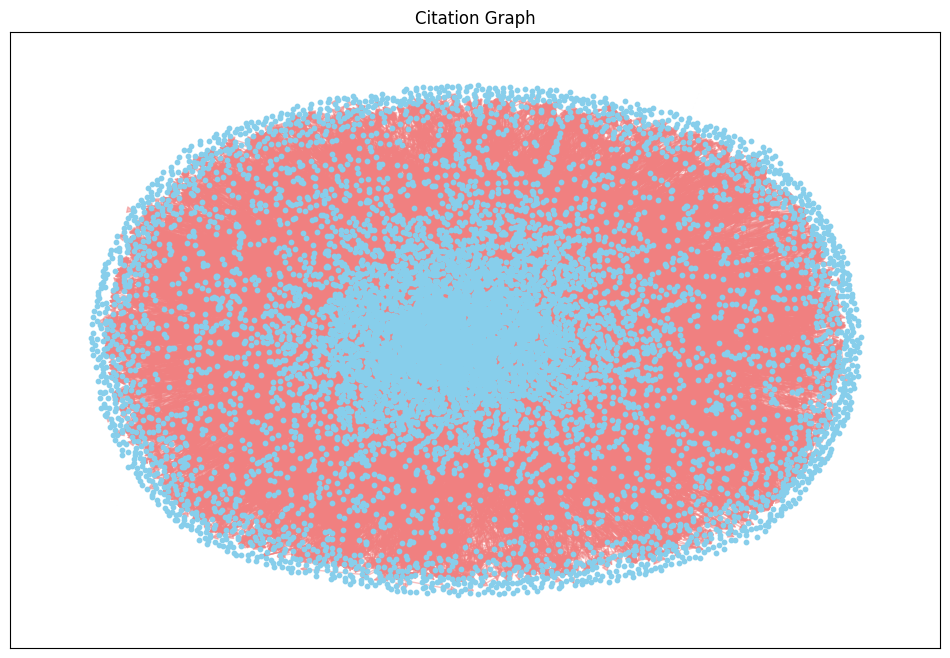

In [80]:
# Create a directed graph
citation_graph = nx.DiGraph()

# Add nodes from the 'id' column
citation_nodes = top_10000_papers['id'].tolist()
citation_graph.add_nodes_from(citation_nodes)

# Create a dictionary to store authors' names
authors_names = dict()

# Function to update authors_names dictionary
def update_authors_names(row):
    if not pd.isna(row['author_name']):
        # Update authors_names dictionary with author_id as key and author_name as value
        authors_names.update(zip(row['author_id'].split(';'), row['author_name'].split(';')))

# Apply the function to update authors_names
top_10000_papers.apply(update_authors_names, axis=1)

# Remove 'nan' from authors_names dictionary
authors_names.pop('nan', None)

# Iterate over each row in the DataFrame
for _, row in top_10000_papers.iterrows():
    references = row['references']
    if not pd.isna(references):
        # Extract cited papers from references, ensuring they are integers and in citation_nodes
        cited_papers = [int(x) for x in references.split(';') if x.isdigit() and int(x) in citation_nodes]
        # Add edges to the Citation Graph
        citation_graph.add_edges_from([(row['id'], cited) for cited in cited_papers])

# Visualizing the citation graph 
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(citation_graph)

# Draw nodes with colors and small size
nx.draw_networkx_nodes(citation_graph, pos, node_size=10, node_color='skyblue')

# Draw edges with a different color
nx.draw_networkx_edges(citation_graph, pos, edge_color='lightcoral', alpha=0.5)

# Set the plot title
plt.title("Citation Graph")

# Display the plot
plt.show()

This graph is too big, you can't really see the edges, so I decided to create a subgraph to visualize the strongest connected component in this graph.

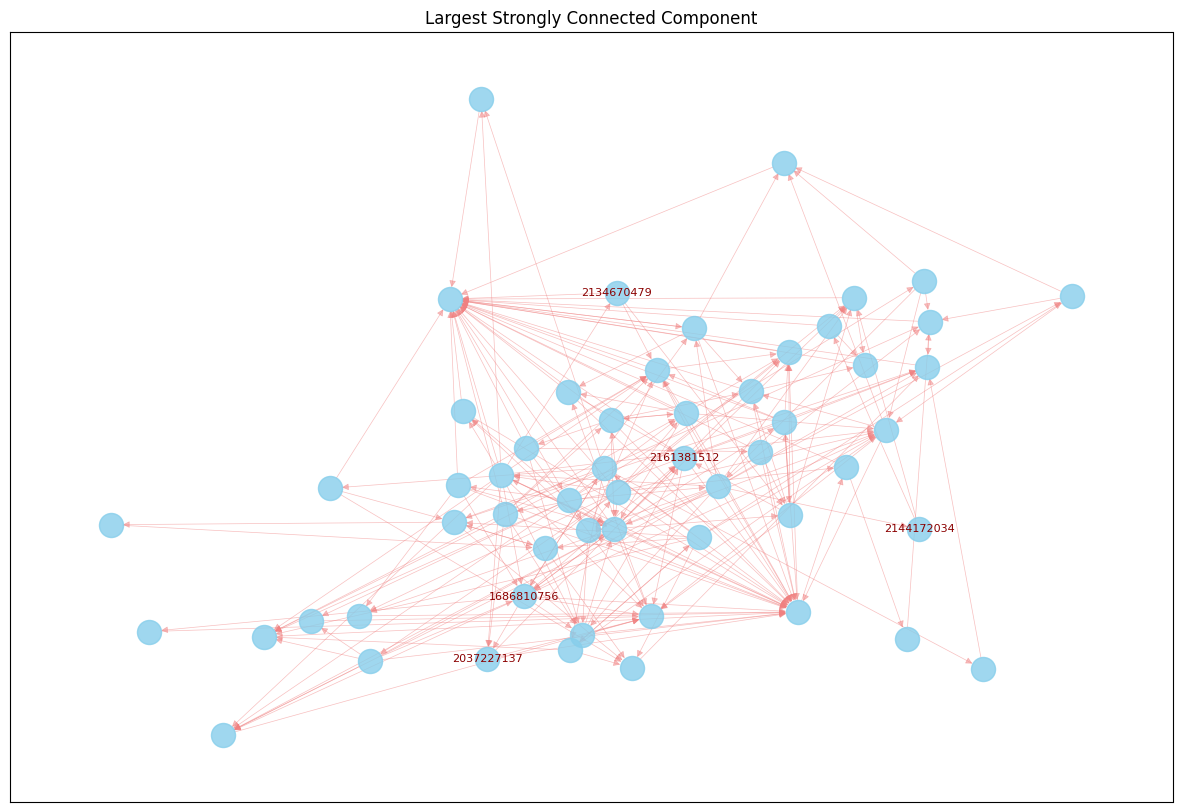

In [81]:
# Find the largest strongly connected component
largest_scc = max(nx.strongly_connected_components(citation_graph), key=len)

# Create a subgraph for the largest strongly connected component
largest_scc_graph = citation_graph.subgraph(largest_scc)

# Visualize the largest strongly connected component with improved colors and layout
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(largest_scc_graph, seed=42)  # Improved layout with seed for reproducibility

node_color = 'skyblue'
edge_color = 'lightcoral'
node_size = 300
edge_width = 0.5

# Draw nodes and edges
nx.draw_networkx_nodes(largest_scc_graph, pos, node_size=node_size, node_color=node_color, alpha=0.8)
nx.draw_networkx_edges(largest_scc_graph, pos, edge_color=edge_color, width=edge_width, alpha=0.5)

# Label a few nodes for better identification
label_nodes = {node: node for node in list(largest_scc)[:5]}
nx.draw_networkx_labels(largest_scc_graph, pos, labels=label_nodes, font_size=8, font_color='darkred')

# Set the plot title
plt.title("Largest Strongly Connected Component")

# Display the plot
plt.show()

In [82]:
# Save graph for the command line question
nx.write_graphml(citation_graph, 'citation_graph.graphml')

### Collaboration Graph
1. This graph should represent the collaborations of the paper's authors. This graph should be weighted and undirected. Consider an appropriate weighting scheme for your edges to make your graph weighted.
2. The authors of these papers are nodes
3. Only consider the collaborations between the authors of these 10,000 papers and ignore the rest.

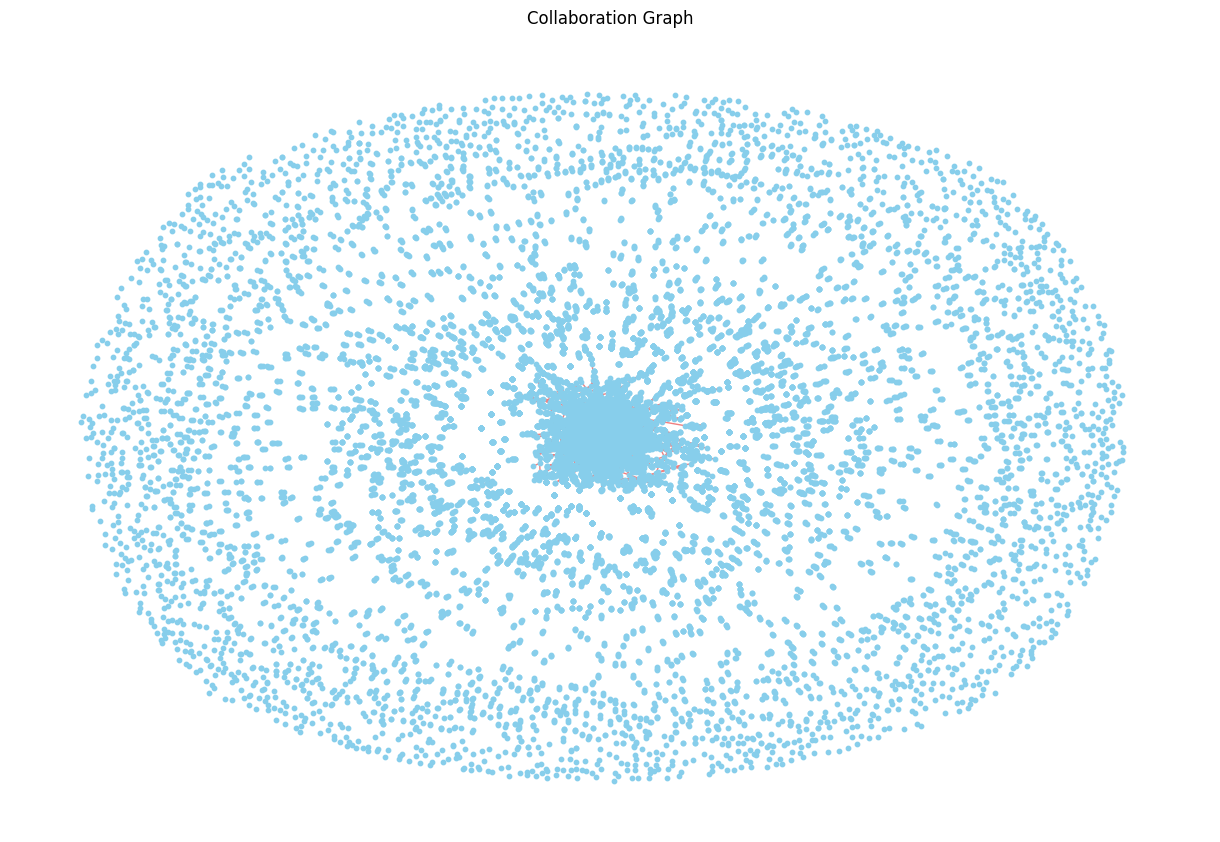

In [83]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to extract unique authors from a series and add them as nodes to the graph
def extract_and_add_nodes(graph, series):
    # Split the series using ';' as a delimiter, explode the values into separate rows, drop NA values, and get unique authors
    authors = series.str.split(';').explode().dropna().unique()
    # Add nodes to the graph for each unique author
    graph.add_nodes_from(authors)

# Create an undirected graph for collaboration
collaboration_graph = nx.Graph()

# Call the function to add nodes to the collaboration graph based on author names in the dataframe
extract_and_add_nodes(collaboration_graph, top_10000_papers['author_name'])

# Iterate through each row in the dataframe
for _, row in top_10000_papers.iterrows():
    # Get the author names as a string
    authors_ids = str(row['author_name'])
    
    # Check if author names exist and are not 'nan'
    if authors_ids and authors_ids != 'nan':
        # Split author names into a list
        authors_ids = authors_ids.split(';')

        # Iterate through pairs of authors
        for author1 in authors_ids:
            for author2 in authors_ids:
                # Check if the authors are different and exist in the collaboration graph
                if author1 != author2 and author1 in collaboration_graph.nodes and author2 in collaboration_graph.nodes:
                    # Check if there is already an edge between the authors
                    if collaboration_graph.has_edge(author1, author2):
                        # If an edge exists, increment the weight and add the title to the list of titles
                        collaboration_graph[author1][author2]['weight'] += 1
                        collaboration_graph[author1][author2]['titles'].append(row['title']) 
                    else:
                        # If no edge exists, add a new edge with weight 1 and a list containing the title
                        collaboration_graph.add_edge(author1, author2, weight=1, titles=[row['title']])

# Remove the 'nan' node from the graph
collaboration_graph.remove_node('nan')

# Convert lists in edge attributes to strings
for u, v, data in collaboration_graph.edges(data=True):
    data['titles'] = ', '.join(data['titles'])

# Save the collaboration graph to GraphML
nx.write_graphml(collaboration_graph, 'collaboration_graph.graphml')

# Plot the collaboration graph using spring layout
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(collaboration_graph)
nx.draw(collaboration_graph, pos, node_size=10, node_color='skyblue', edge_color='lightcoral', with_labels=False)
plt.title("Collaboration Graph")
plt.show()

In [84]:
# Save graph
nx.write_graphml(collaboration_graph, 'collaboration_graph.graphml')

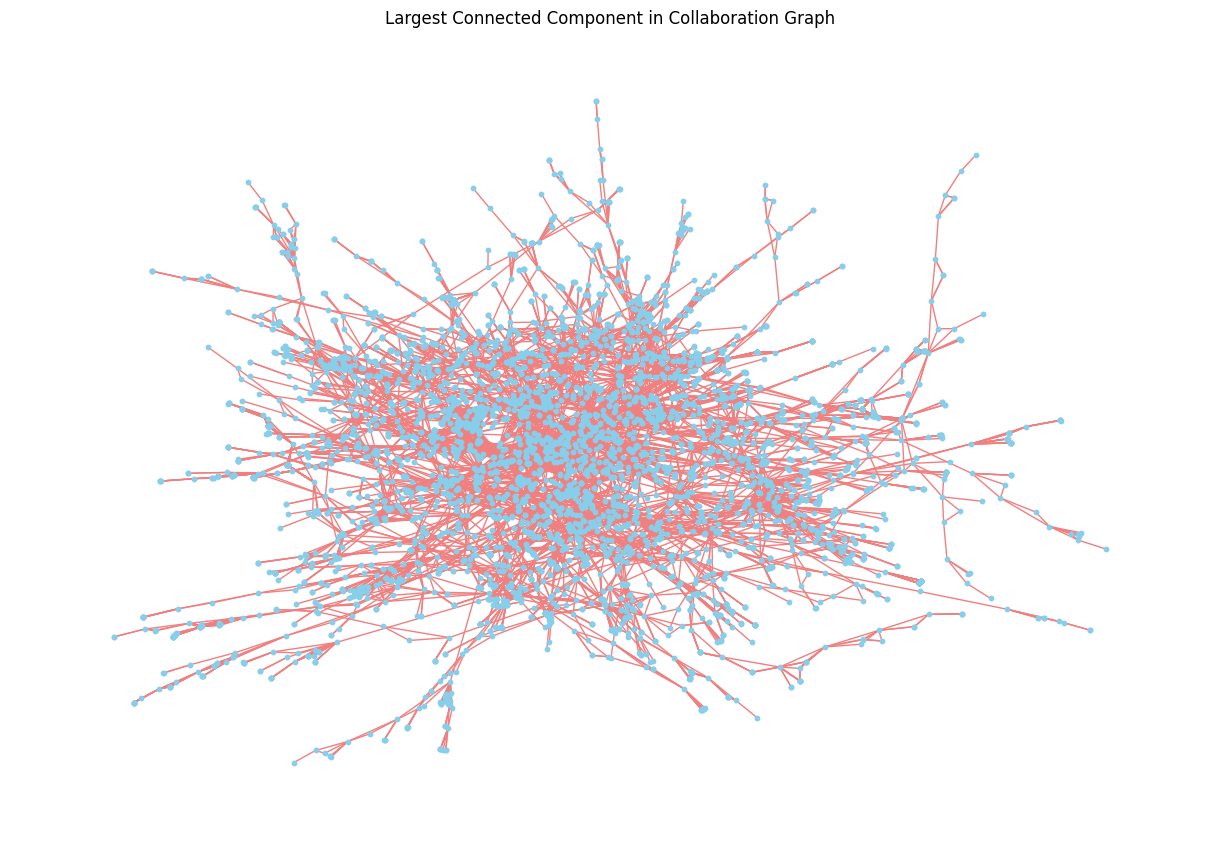

In [85]:
# Find connected components in the collaboration graph
connected_components = list(nx.connected_components(collaboration_graph))

# Find the largest connected component
largest_component = max(connected_components, key=len)

# Create a subgraph containing only the largest connected component
largest_component_graph = collaboration_graph.subgraph(largest_component)

# Plot the largest connected component
plt.figure(figsize=(12, 8))
pos_largest = nx.spring_layout(largest_component_graph)
nx.draw(largest_component_graph, pos_largest, node_size=10, node_color='skyblue', edge_color='lightcoral', with_labels=False)
plt.title("Largest Connected Component in Collaboration Graph")
plt.show()

### Functionality and Visualization 1

This function should examine a graph and report on some of its features. The input and report that this function should produce are shown below.

Input:

The graph
The name of the graph  
Output:

The number of the nodes in the graph  
The number of the edges in the graph  
The graph density  
The graph degree distribution  
The average degree of the graph  
The graph hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)  
Whether the graph is dense or sparse  

A table containing the following general information about the graph:  
Number of nodes in the graph  
Number of the edges in the graph  
Density of the graph  
Average degree of the graph  
Whether the network is sparse or dense  
A table that lists the graph's hubs  
A plot depicting the distribution of the citations received by papers (Citation graph)  
A plot depicting the distribution of the given citations by papers (Citation graph)  
A plot depicting the number of collaborations of the author (Collaboration graph)  

In [86]:
def analyze_graph(graph, graph_name):
    # Number of nodes
    num_nodes = len(graph.nodes())

    # Number of edges
    num_edges = len(graph.edges())

    # Graph density
    density = nx.density(graph)

    # Degree distribution
    degree_distribution = [d for n, d in graph.degree()]

    # Average degree
    avg_degree = np.mean(degree_distribution)

    # 95th percentile of the degree distribution
    percentile_95 = np.percentile(degree_distribution, 95)

    # Graph hubs (nodes with degrees > 95th percentile)
    hubs = [n for n, d in graph.degree() if d > percentile_95]

    # Check if the graph is dense or sparse
    is_dense = 'Dense' if density >= 0.5 else 'Sparse'

    # Create a table with the required information
    table_data = [
        ['Name of Graph', graph_name],
        ['Number of nodes in the Graph', num_nodes],
        ['Number of edges in the Graph', num_edges],
        ['Density of the Graph', density],
        ['Average degree of the Graph', avg_degree],
        ['The Graph is', is_dense]
    ]

    # Display the general information table using tabulate
    print(tabulate(table_data, tablefmt='grid', numalign="right"))

    # Plot depicting the distribution of degrees
    plt.figure(figsize=(12, 6))
    plt.hist(degree_distribution, bins=20, color='skyblue', alpha=0.7)
    plt.title("Degree Distribution of the Graph")
    plt.xlabel("Node Degree")
    plt.ylabel("Number of Nodes")
    plt.show()

    # Plot depicting the hubs in the graph
    plt.figure(figsize=(12, 6))
    plt.hist(degree_distribution, bins=20, color='skyblue', alpha=0.7)
    plt.axvline(percentile_95, color='red', linestyle='dashed', linewidth=2, label='95th Percentile')
    plt.title("Hubs in the Graph")
    plt.xlabel("Node Degree")
    plt.ylabel("Number of Nodes")
    plt.legend()
    plt.show()

    # Create a table for hubs
    hubs_table_data = [
        ['Hub Nodes'],
        *[[hub] for hub in hubs]
    ]

    # Display the hubs table using tabulate
    print("\nHubs Table:")
    print(tabulate(hubs_table_data, tablefmt='grid', numalign="right"))

+------------------------------+-----------------------+
| Name of Graph                | Citation Graph        |
+------------------------------+-----------------------+
| Number of nodes in the Graph | 10000                 |
+------------------------------+-----------------------+
| Number of edges in the Graph | 52289                 |
+------------------------------+-----------------------+
| Density of the Graph         | 0.0005229422942294229 |
+------------------------------+-----------------------+
| Average degree of the Graph  | 10.4578               |
+------------------------------+-----------------------+
| The Graph is                 | Sparse                |
+------------------------------+-----------------------+


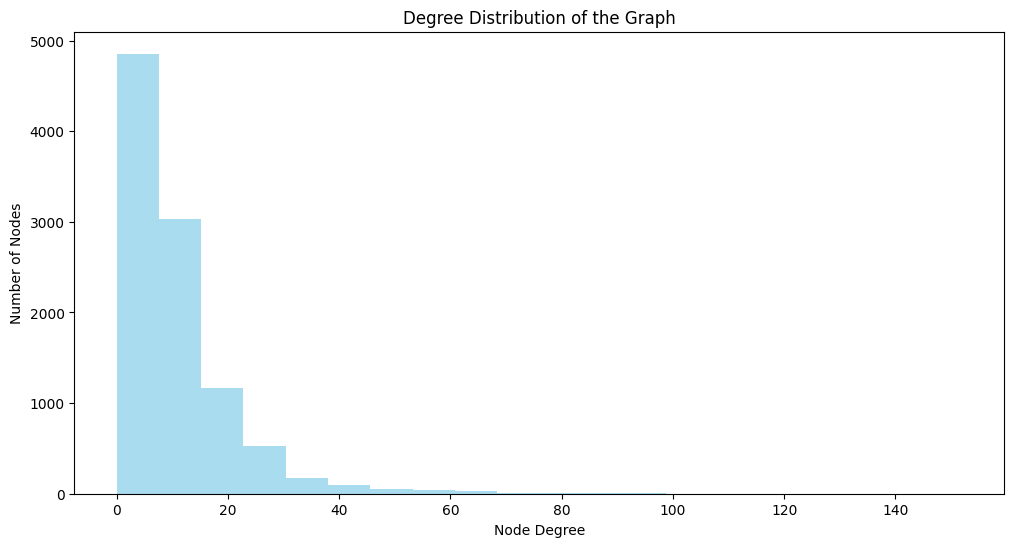

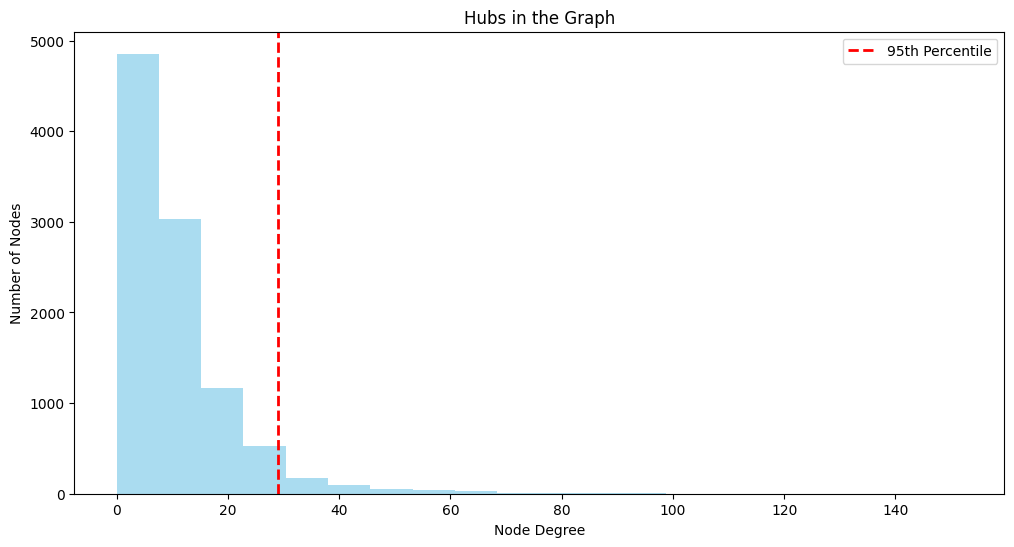


Hubs Table:
+------------+
| Hub Nodes  |
+------------+
| 2041404167 |
+------------+
| 1639032689 |
+------------+
| 2912565176 |
+------------+
| 2151103935 |
+------------+
| 2911964244 |
+------------+
| 2153635508 |
+------------+
| 2156909104 |
+------------+
| 1791587663 |
+------------+
| 2119821739 |
+------------+
| 1995875735 |
+------------+
| 2145023731 |
+------------+
| 2161969291 |
+------------+
| 1880262756 |
+------------+
| 1686810756 |
+------------+
| 2121863487 |
+------------+
| 2011039300 |
+------------+
| 2163605009 |
+------------+
| 2132984323 |
+------------+
| 2064675550 |
+------------+
| 2125055259 |
+------------+
| 2085261163 |
+------------+
| 2296616510 |
+------------+
| 2169528473 |
+------------+
| 2194775991 |
+------------+
| 1667165204 |
+------------+
| 2100379340 |
+------------+
| 2104095591 |
+------------+
| 2173213060 |
+------------+
| 2159080219 |
+------------+
| 2139212933 |
+------------+
| 2124637492 |
+------------+
| 1480376833

In [87]:
analyze_graph(citation_graph, "Citation Graph")

+------------------------------+-----------------------+
| Name of Graph                | Collaboration Graph   |
+------------------------------+-----------------------+
| Number of nodes in the Graph | 18399                 |
+------------------------------+-----------------------+
| Number of edges in the Graph | 53272                 |
+------------------------------+-----------------------+
| Density of the Graph         | 0.0003147488584223984 |
+------------------------------+-----------------------+
| Average degree of the Graph  | 5.790749497255286     |
+------------------------------+-----------------------+
| The Graph is                 | Sparse                |
+------------------------------+-----------------------+


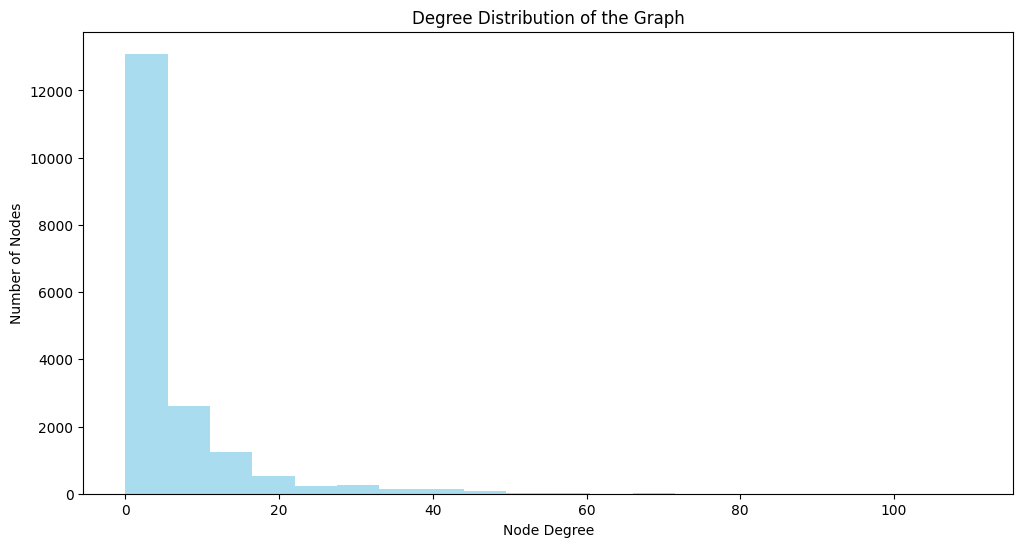

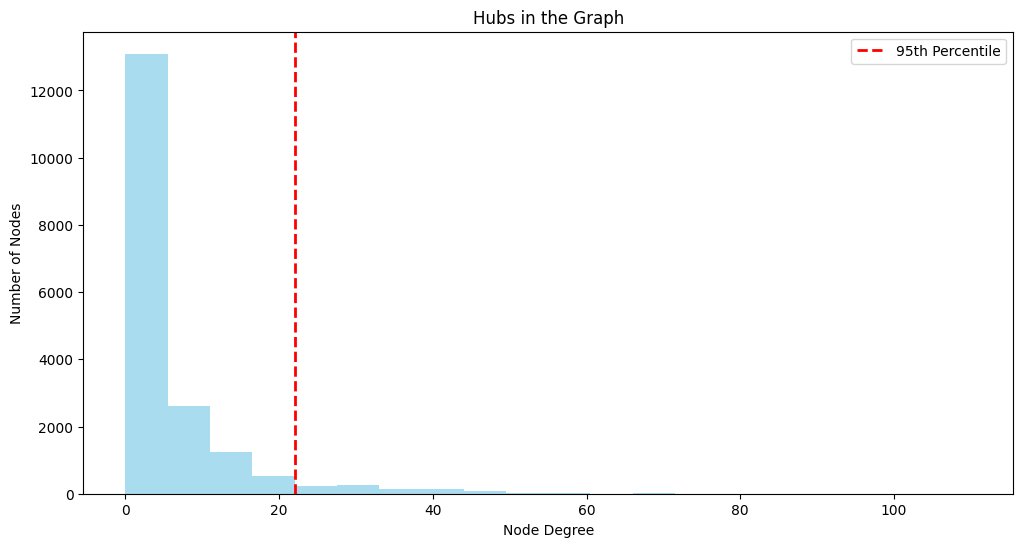


Hubs Table:
+-----------------------------------------+
| Hub Nodes                               |
+-----------------------------------------+
| Andrew Y. Ng                            |
+-----------------------------------------+
| Michael I. Jordan                       |
+-----------------------------------------+
| Ilya Sutskever                          |
+-----------------------------------------+
| Jeffrey Dean                            |
+-----------------------------------------+
| Sanjay Ghemawat                         |
+-----------------------------------------+
| Yoshua Bengio                           |
+-----------------------------------------+
| Li Fei-Fei                              |
+-----------------------------------------+
| Ion Stoica                              |
+-----------------------------------------+
| Robert Morris                           |
+-----------------------------------------+
| Hari Balakrishnan                       |
+------------------

In [88]:
analyze_graph(collaboration_graph, "Collaboration Graph")

### Functionality and Visualization 2
Using this functionality, you will identify the papers/authors who have significantly contributed to this field of study. For this analysis, focusing solely on the number of citations for the paper or the number of collaborations of the authors can be misleading. You will examine this using various centrality measurements.

Input:

The graph  
A node of the graph (paper/author)  
The name of the graph  
Output:  

The centrality of the node, calculated based on the following centrality measurements:  
Betweeness  
PageRank  
ClosenessCentrality  
DegreeCentrality  

In [106]:
# Function to calculate various centrality metrics for a given node in a graph
def calculate_centralities(graph, node):
    # Calculate betweenness centrality for the specified node
    betweenness_centrality = nx.betweenness_centrality(graph)[node]
    
    # Calculate pagerank centrality for the specified node
    pagerank_centrality = nx.pagerank(graph)[node]
    
    # Calculate closeness centrality for the specified node
    closeness_centrality = nx.closeness_centrality(graph)[node]
    
    # Calculate degree centrality for the specified node
    degree_centrality = nx.degree_centrality(graph)[node]

    return betweenness_centrality, pagerank_centrality, closeness_centrality, degree_centrality

# Function to print centrality metrics in a tabular format
def print_centralities_table(node, graph_name, centrality_metrics):
    # Define table headers
    headers = ["Node", "Graph Name", "Betweenness Centrality", "Pagerank Centrality", "Closeness Centrality", "Degree Centrality"]
    
    # Combine node, graph name, and centrality metrics into a list
    data = [node, graph_name] + list(centrality_metrics)
    
    # Generate a pretty table using the tabulate library
    table = tabulate([data], headers, tablefmt="pretty")
    
    # Print the table
    print(table)

# Function to run centrality analysis on a specific node in a graph
def run_analysis(graph, specific_node):
    # Calculate centrality metrics for the specified node
    betweenness_centrality, pagerank_centrality, closeness_centrality, degree_centrality = calculate_centralities(graph, specific_node)

    # Print the centrality metrics in a table
    print_centralities_table(specific_node, 'citation_graph', (betweenness_centrality, pagerank_centrality, closeness_centrality, degree_centrality))

if __name__ == "__main__":
    # Specify the node for analysis
    specific_node = 2117085697
    
    # Assume citation_graph is defined somewhere before this point
    run_analysis(citation_graph, specific_node)

+------------+----------------+------------------------+------------------------+----------------------+-----------------------+
|    Node    |   Graph Name   | Betweenness Centrality |  Pagerank Centrality   | Closeness Centrality |   Degree Centrality   |
+------------+----------------+------------------------+------------------------+----------------------+-----------------------+
| 2117085697 | citation_graph | 4.109858638520146e-06  | 0.00014361685400613903 | 0.00467413240639445  | 0.0008000800080008001 |
+------------+----------------+------------------------+------------------------+----------------------+-----------------------+


### Functionality 3
Input:

The graph data
A sequence of authors_a = [a_2, ..., a_{n-1}]
Initial node a_1 and an end node a_n
N: denoting the top N authors whose data should be considered
Output:

The shortest walk of collaborations you need to read to get from author a_1 to author a_n and the papers you need to cross to realize this walk.
Considerations: For this functionality, you must implement an algorithm that returns the shortest walk that goes from node a_j to a_n, which visits in order the nodes in a. The choice of a_j and a_n can be made randomly (or if it improves the performance of the algorithm, you can also define it in any other way)

Important Notes:

This algorithm should be run only on the collaboration graph.
The algorithm needs to handle the case that the graph is not connected. Thus, only some nodes in a are reachable from a_1. In such a scenario, it is enough to let the program give in the output the string "There is no such path."
Since we are dealing with walks, you can pass on the same node a_i more than once, but you must preserve order. It means you can go back to any author node any time you want, assuming that the order in which you visit the required nodes is still the same.
Once you completed your implementation, ask chatGPT for a different one leveraging another approach in solving the shortest path and prove whether this implementation is correct

### Functionality 4
Input:  

The graph data    
authorA: a paper to which will relate sub-graph G_a  
authorB: a paper to which will relate sub-graph G_b  
N: denoting the top N authors that their data should be considered  
Output:  

The minimum number of edges (by considering their weights) required to disconnect the original graph in two disconnected subgraphs: G_a and G_b.

Print the number of the links that should be disconnected  
Plot the original graph  
Plot the graph after removing the links and identify the two nodes  

### Functionality and Visualization 5

Input:

The graph data  
N: denoting the top N papers that their data should be considered  
Paper_1: denoting the name of one of the papers  
Paper_2: denoting the name of one of the papers  
Output:  

The minimum number of edges that should be removed to form communities
A list of communities, each containing a list of papers that belong to them.
Whether the Paper_1 and Paper_2 belongs to the same community.
We anticipate seeing the Functionality 5 report in Visualization 5. To be more specific, we expect you to have the following report format:

Print the number of links that should be removed to have the communities  
A table depicting the communities and the papers that belong to each community  
Plot the original graph  
Plot the graph showing the communities in the network  
Plot the final graph and identify the community/communities of Paper_1 and Paper_2  

### Commandline Question


### Question 1:
**Objective:** Identify a node acting as a significant connector between different parts of the graph.
1. **Node Identification:**
   - Extract target node IDs from the graph using command-line tools.
2. **Count and Sort:**
   - Count occurrences of each node to determine how many connections it has.
   - Sort nodes based on the count in descending order to highlight the most connected nodes.
3. **Top Node Selection:**
   - Choose the node with the highest count, indicating that it is the most connected.
4. **Output Presentation:**
   - Display the ID of the most connected node, indicating its importance as a connector in the graph.

### Question 2:
**Objective:** Understand how the degree of citation varies among graph nodes.
1. **Node Identification:**
   - Extract target node IDs from the graph using command-line tools.
2. **Count and Sort:**
   - Count occurrences of each node to determine its connectivity.
   - Sort nodes based on the count in descending order to highlight the most connected nodes.
3. **Degree Extraction:**
   - Extract the degrees (connectivity) of each node.
4. **Unique Degrees:**
   - Remove duplicate degrees to get a clear picture of the distinct levels of connectivity.
5. **Format Output:**
   - Present the range of degrees as a comma-separated list to illustrate how the degree of citation varies.
6. **Output Presentation:**
   - Display the range of degrees among graph nodes, providing insight into the distribution of connectivity.

### Question 3:
**Objective:** Calculate the average length of the shortest path among nodes.
1. **Python Calculation:**
   - Utilize Python with the NetworkX library for graph operations.
2. **Graph Loading:**
   - Read the directed and unweighted citation graph from the specified file.
3. **Strongly Connected Check:**
   - Verify if the graph is strongly connected.
     - **If Strongly Connected:**
       - Calculate the average shortest path length for the entire graph, providing a measure of the overall connectivity.
     - **If Not Strongly Connected:**
       - Print a message indicating that the graph is not strongly connected.
       - Calculate the average shortest path length for each connected component, providing insights into the connectivity within individual subgraphs.
       - Sum up the average distances of each component.
4. **Output Presentation:**
   - Display the final average shortest path length, considering whether the graph is strongly connected or consists of multiple connected components.

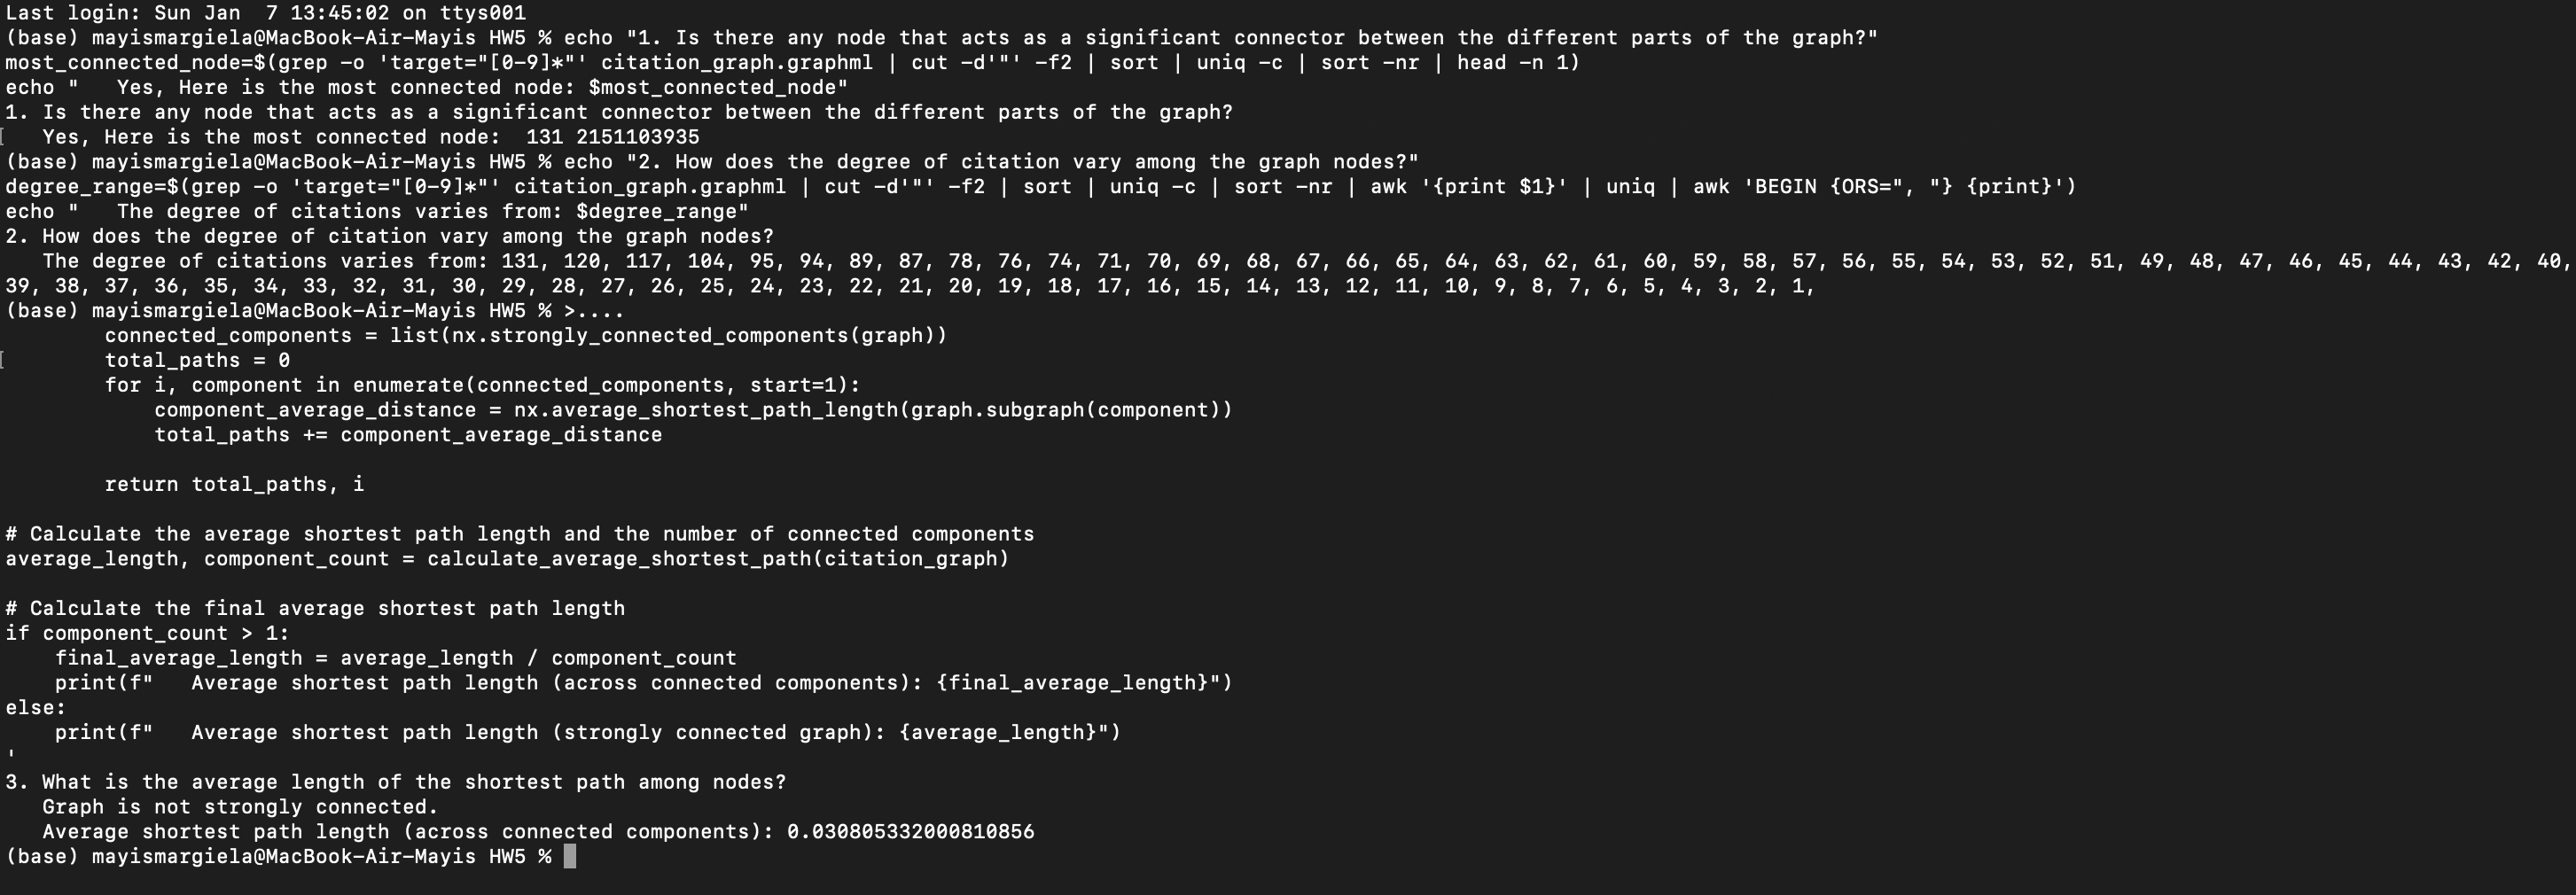

### Algorithmic Question
### Part A

In [127]:
# Function to get input data including N, M, S, and the list of skills
def get_input_data():
    try:
        # Parse input for N, M, and S
        num_athletes, num_required_skills, num_skills_per_athlete = map(int, input("Enter N, M, and S separated by space: ").split())
        # Parse input for the list of skills
        required_skills = list(input("Enter the required skills separated by space: ").split())
        return num_athletes, num_required_skills, num_skills_per_athlete, required_skills
    except ValueError:
        # Handle invalid input (non-numeric values)
        print("Invalid input. Please enter numeric values.")
        exit(1)

# Function to get a list of athlete skills including athlete ID and associated skills
def get_athlete_skills_list(num_athletes, num_skills_per_athlete):
    athlete_skills_list = []

    for _ in range(num_athletes):
        try:
            # Parse input for athlete ID
            athlete_id = int(input("Enter athlete ID: "))
            
            # Initialize skills dictionary for the current athlete
            skills = {}
            for _ in range(num_skills_per_athlete):
                # Parse input for each skill and its level
                skill, level = input("Enter skill and level separated by space: ").split()
                skills[skill] = int(level)

            # Append the athlete's ID and skills to the list
            athlete_skills_list.append({'id': athlete_id, 'skills': skills})
        except ValueError:
            # Handle invalid input (non-numeric values)
            print("Invalid input. Please enter numeric values for ID and skill levels.")
            exit(1)

    return athlete_skills_list

# Function to compute the maximum score based on required skills and athlete skills
def compute_max_score(required_skills, athlete_skills_list):
    # Set to keep track of athlete IDs
    athlete_ids = set()
    # List to store the maximum score for each required skill
    skill_max_scores = [0] * len(required_skills)

    # Iterate over required skills
    for i, skill in enumerate(required_skills):
        max_score = 0

        # Iterate over athlete skills to find the highest score for the current skill
        for athlete in athlete_skills_list:
            athlete_id = athlete['id']

            # Check if the athlete has the required skill and hasn't been used
            if athlete_id not in athlete_ids and skill in athlete['skills']:
                score = athlete['skills'][skill]

                # Update max score if the current athlete has a higher score
                if score > max_score:
                    max_score = score
                    athlete_ids.add(athlete_id)

        # Store the maximum score for the current skill
        skill_max_scores[i] = max_score

    # Return the sum of all skill max scores
    return sum(skill_max_scores)

# Main program to execute the entire process
def main_program():
    # Get input data
    num_athletes, num_required_skills, num_skills_per_athlete, required_skills = get_input_data()
    # Get the list of athlete skills
    athlete_skills_list = get_athlete_skills_list(num_athletes, num_skills_per_athlete)
    # Compute and print the maximum score
    max_score = compute_max_score(required_skills, athlete_skills_list)
    print(f"The maximum score is: {max_score}")

# Execute the main program if the script is run as the main module
if __name__ == "__main__":
    main_program()

Enter N, M, and S separated by space:  14 10 1
Enter the required skills separated by space:  SWM VOL ATH VOL VOL BSK HCK BSK SWM BSK
Enter athlete ID:  1
Enter skill and level separated by space:  BSK 98
Enter athlete ID:  2
Enter skill and level separated by space:  ATH 14
Enter athlete ID:  3
Enter skill and level separated by space:  HCK 82
Enter athlete ID:  4
Enter skill and level separated by space:  HCK 9
Enter athlete ID:  5
Enter skill and level separated by space:  FTB 90
Enter athlete ID:  6
Enter skill and level separated by space:  ATH 52
Enter athlete ID:  7
Enter skill and level separated by space:  HCK 95
Enter athlete ID:  8
Enter skill and level separated by space:  TEN 85
Enter athlete ID:  9
Enter skill and level separated by space:  RGB 46
Enter athlete ID:  10
Enter skill and level separated by space:  SWM 16
Enter athlete ID:  11
Enter skill and level separated by space:  VOL 32
Enter athlete ID:  12
Enter skill and level separated by space:  SOC 41
Enter athlet

The maximum score is: 370


#### 1. Input Gathering:
The program starts by prompting the user to input three integers N, M, and S, separated by spaces. These represent the number of athletes (N), the number of required skills (M), and the number of skills each athlete possesses (S). Additionally, the user is asked to input the list of required skills. The input data is then parsed and returned by the `get_input_data()` function.

#### 2. Athlete Skills Input:
The `get_athlete_skills_list()` function is responsible for collecting information about each athlete's skills. It iterates N times, prompting the user to enter an athlete ID and the associated skills with their corresponding levels. This information is stored in a list of dictionaries, where each dictionary contains an athlete's ID and their skills.

#### 3. Computing Maximum Score:
The `compute_max_score()` function calculates the maximum possible score based on the required skills and the skills of the athletes. It utilizes the information gathered in the previous steps.

   - It initializes a set (`athlete_ids`) to keep track of athlete IDs that have been considered.
   - It also initializes a list (`skill_max_scores`) to store the maximum score for each required skill.

   - For each required skill:
      - It iterates over the list of athletes to find the athlete with the highest score for the current skill.
      - It ensures that the athlete hasn't been considered before and possesses the required skill.
      - The maximum score for the skill is updated if the current athlete has a higher score.

   - Finally, the function returns the sum of all skill max scores.

#### 4. Main Program Execution:
The `main_program()` function acts as the driver for the entire process. It calls the `get_input_data()` function to retrieve the input parameters, then calls `get_athlete_skills_list()` to gather information about each athlete's skills, and finally, it calls `compute_max_score()` to determine the maximum score. The result is printed to the console.

#### 5. Running the Program:
The script checks if it is being run as the main module (`__name__ == "__main__"`) and, if true, executes the main program.

#### Overall:
The algorithm is designed to find the maximum possible score based on a set of required skills and the skills possessed by a group of athletes. It ensures that each athlete is considered only once, and for each required skill, the athlete with the highest level of that skill is selected. The final output is the sum of the maximum scores for all required skills. The algorithm is structured with functions to enhance modularity and readability.

#### Time Complexity of the Algorithm

Certainly! Let's consolidate the time complexity analysis for the entire algorithm, considering all functions:

#### Overall Time Complexity:
- **`get_input_data()` Function:** O(1) (constant time)
- **`get_athlete_skills_list()` Function:** O(N * S), where N is the number of athletes, and S is the number of skills per athlete.
- **`compute_max_score()` Function:** O(M * N), where M is the number of required skills, and N is the number of athletes.
- **Main Program (`main_program()`):** The overall time complexity is determined by the most complex operation, which is `compute_max_score()`. Therefore, the overall time complexity is O(M * N).

#### Explanation:
- The `get_input_data()` function involves constant-time operations, which have a negligible impact on overall time complexity.
- The `get_athlete_skills_list()` function contributes O(N * S), where N is the number of athletes and S is the number of skills per athlete.
- The most significant factor is the `compute_max_score()` function with a time complexity of O(M * N), where M is the number of required skills, and N is the number of athletes.
- The overall time complexity of the algorithm is dominated by the product of the number of required skills (M) and the number of athletes (N).

#### Summary:
- **Overall Time Complexity:** O(M * N), where M is the number of required skills, and N is the number of athletes.
- The time complexity is proportional to the product of the number of required skills and the number of athletes.

#### Time complexity of this algorithm is Polynomial

### If S=1 how does the time complexity of an optimal algorithm to solve this problem change?

If S (the number of skills per athlete) is 1, the time complexity of the algorithm remains O(N * M), where N is the number of athletes and M is the number of required skills. In this specific algorithm, the value of S does not affect the polynomial nature of the time complexity.

Changing the value of S to 1 means that each athlete has only one skill, which simplifies the inner loops in the `get_athlete_skills_list()` and `compute_max_score()` functions. However, the overall behavior of the time complexity remains polynomial, as it is still proportional to the product of the number of athletes (N) and the number of required skills (M).

### PART B

### Proving NP-Completeness:

The problem described can be considered an extension of the Set Cover Problem, which is known to be NP-complete. The Set Cover Problem involves selecting the minimum number of sets from a given collection such that the union of these sets covers all elements.

In our problem:
- The set of skills T corresponds to the elements that need to be covered.
- Individuals (nodes) in the graph correspond to sets.
- Edges between nodes with weights represent the effort required for those individuals to work well together.

The goal is to find a subset of individuals (nodes) such that the union of their corresponding skills covers all the required skills and has the minimum effort to work well together (minimum spanning tree). 

#### Proof Sketch:
1. **Reduction from Set Cover Problem:** Given an instance of the Set Cover Problem, construct a graph where each set corresponds to a node, and the elements in each set correspond to the skills of the individual represented by that node. Set the weight of each edge between nodes to be the effort required for those individuals to work well together.

2. **Mapping to Set Cover:** A solution to the constructed graph corresponds to a solution to the Set Cover Problem, and vice versa.

3. **Effort Minimization Corresponds to Set Cover Minimization:** The minimum spanning tree corresponds to selecting the minimum number of sets to cover all elements.

Thus, the problem is at least as hard as the NP-complete Set Cover Problem, making it NP-complete as well.

### Heuristic:

A possible heuristic to approximate the best solution for this problem is a Greedy Algorithm:

1. **Initialization:** Start with an empty set V'.
2. **Greedy Selection:** In each iteration, select the node that covers the maximum number of additional required skills while minimizing the effort to work well with the current set V'. Add this node to V'.
3. **Repeat:** Continue the process until all required skills are covered.

### Time Complexity of Heuristic:

The time complexity of the greedy heuristic is dominated by the sorting and selection of nodes in each iteration. Let N be the number of nodes (individuals) and E be the number of edges in the graph:

- **Sorting:** O(N log N)
- **Selection in Each Iteration:** O(E) (linear in the number of edges)

Therefore, the overall time complexity of the heuristic is O(N log N + E). The efficiency of this heuristic depends on the specific characteristics of the input graph and how well the greedy strategy aligns with the problem's requirements. It provides a fast but approximate solution to the optimization problem.